In [ ]:
#!unzip fer2013.zip

In [ ]:
#!pip install matplotlib
!pip install torch-summary

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob 
import itertools
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def collate_fn(batch):
    # Filter failed images first
    batch = list(filter(lambda x: x is not None, batch))
    
    # Now collate into mini-batches
    images = torch.stack([b[0] for b in batch])
    labels = torch.LongTensor([b[1] for b in batch])
    
    return images, labels

In [ ]:
#Set up dataset + dataloader for FER2013

data_dir='./fer2013'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                for x in ['train', 'test']}
print(len(image_datasets['train'][0]))

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0, collate_fn=collate_fn)
              for x in ['train', 'test']}

2


In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 28709, 'test': 7178}
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 3, 224, 224])
torch.Size([3, 228, 906])


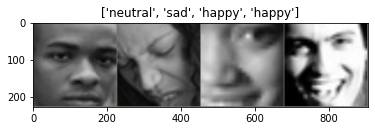

torch.Size([3, 224, 224])
0
28709


In [ ]:
print(type(dataloaders['train']))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
#print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

print(image_datasets['train'][0][0].shape)
print(image_datasets['train'][0][1])
print(len(image_datasets['train']))
#for image in image_datasets['train']:
#    print(image[0][0].shape)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Load a pretrained model and reset final fully connected layer for this particular classification problem.
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 7)

# Move the model to the correct device (when we have access to a GPU)
model_ft = model_ft.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Let's set our loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# Setup the optimizer to update the model parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Now, let’s write a general function to train a model. 
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #print("Iterate over data")
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                #print("zero_grad")
                optimizer.zero_grad()

                # forward
                # track history if only in train
                #print("Track gistory if only in train")
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #print("backward + optimize only if in training phase")
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Train and evaluate.  
# It should take around 10 min on CPU. On GPU, it takes less than a minute.
from torchsummary import summary

#summary(model_ft, (1, 48, 48))
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6770 Acc: 0.3588
test Loss: 1.3700 Acc: 0.5322

Epoch 1/9
----------
train Loss: 1.4251 Acc: 0.4537
test Loss: 1.1835 Acc: 0.5671

Epoch 2/9
----------
train Loss: 1.3415 Acc: 0.4877
test Loss: 1.1333 Acc: 0.5971

Epoch 3/9
----------
train Loss: 1.2924 Acc: 0.5072
test Loss: 1.2397 Acc: 0.5534

Epoch 4/9
----------
train Loss: 1.2563 Acc: 0.5189
test Loss: 1.0462 Acc: 0.6108

Epoch 5/9
----------
train Loss: 1.2302 Acc: 0.5303
test Loss: 1.0731 Acc: 0.6089

Epoch 6/9
----------
train Loss: 1.2041 Acc: 0.5430
test Loss: 1.0000 Acc: 0.6290

Epoch 7/9
----------
train Loss: 1.1032 Acc: 0.5809
test Loss: 0.9602 Acc: 0.6498

Epoch 8/9
----------
train Loss: 1.0855 Acc: 0.5881
test Loss: 0.9399 Acc: 0.6583

Epoch 9/9
----------
train Loss: 1.0690 Acc: 0.5947
test Loss: 0.9569 Acc: 0.6556

Training complete in 35m 59s
Best val Acc: 0.658261


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

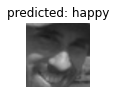

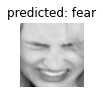

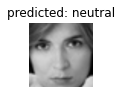

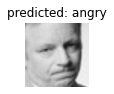

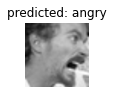

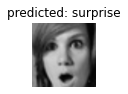

In [ ]:
visualize_model(model_ft)